In [1]:
from lofarantpos.db import LofarAntennaDatabase
import lofarantpos.geo as lofargeo
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import ITRS, EarthLocation, AffineTransform, GCRS, ICRS, SkyCoord, AltAz
import numpy as np
from numpy.linalg import norm

In [2]:
db = LofarAntennaDatabase()

In [3]:
t0 = Time("2019-01-01T01:00")

In [4]:
def station_to_itrs(station_name, time):
    """Returns an astropy ITRS coordinate for a given station (e.g. 'CS001LBA')"""
    x,y,z = db.phase_centres[station_name]
    return ITRS(x=x*u.m, y=y*u.m, z=z*u.m, obstime=time)

In [5]:
def station_to_earthlocation(station_name):
    """Returns an astropy EarthLocation for a given station (e.g. 'CS001LBA')"""
    x,y,z = db.phase_centres[station_name]
    return EarthLocation(x=x*u.m, y=y*u.m, z=z*u.m)

We will test at zenith:

In [6]:
test_coord = AltAz(location=station_to_earthlocation("CS301LBA"),
                  alt=89.0*u.deg, az=0*u.deg, obstime=t0).transform_to(ICRS)

In [7]:
def get_source_location_itrs(coord: SkyCoord, time: Time):
    """Get the ITRS coordinates (as numpy array) as a unit norm 3-vector"""
    coord_itrs = coord.transform_to(ITRS(obstime=time))
    return coord_itrs.cartesian.get_xyz().value

In [8]:
get_source_location_itrs(test_coord, t0)

array([0.58488718, 0.07044567, 0.80804975])

To test whether we computed zenith, let's test whether the ITRS-vector of zenith corresponds to the ITRS-vector that points towards the station phase center.

In [9]:
station_itrs = station_to_itrs('CS301LBA', t0).cartesian.get_xyz().value
station_itrs /= norm(station_itrs)

In [10]:
np.rad2deg(np.arccos(get_source_location_itrs(test_coord, t0).dot(station_itrs)))

1.1853105815488125

Ok, somehow there is an error of about one degree. Let's ignore for now.

Define the dipoles, as unit vectors in the PQR system, and convert them to ETRS.

In [11]:
def get_dipole_etrs(stationname):
    a = np.sqrt(.5)
    return db.pqr_to_etrs[stationname]@np.array([[ a,  a, 0],
                                                 [ a, -a, 0],
                                                 [-a, -a, 0],
                                                 [-a,  a, 0]]).T

Note that we assume here that ITRS = ETRS, which is true to the meter level. (We could use Michiel's `etrsitrs` package here, but I think we've already got enough coordinate frames.)

In [12]:
def get_dipoles_projected(coord, time, stationname):
    """Get the projected dipoles in PQR system, given a SkyCoord and a time"""
    coord_itrs = get_source_location_itrs(coord, time)
    dipole_matrix_etrs = get_dipole_etrs(stationname)
    dipoles_projected_itrs = dipole_matrix_etrs - coord_itrs.dot(dipole_matrix_etrs) * coord_itrs[:, np.newaxis]
    return db.pqr_to_etrs[stationname].transpose().dot(dipoles_projected_itrs)

In [15]:
get_dipoles_projected(test_coord, t0+5*u.hour, "CS301LBA")

array([[ 0.62566348,  0.32978179, -0.62566348, -0.32978179],
       [ 0.75963348, -0.46375179, -0.75963348,  0.46375179],
       [ 0.10514307,  0.48712547, -0.10514307, -0.48712547]])

In [18]:
def plot_rotation(time):
    """Plots projected dipoles on the sky around a J2000 position"""
    fig, ax = plt.subplots(1)
    dipoles_projected = get_dipoles_projected(test_coord, time, "CS301LBA")
    x, y = dipoles_projected[:2]
    ax.grid()
    ax.arrow(x[0], y[0], x[2] - x[0], y[2] - y[0], head_width=0.1, color='r',
             length_includes_head=True)
    ax.arrow(x[1], y[1], x[3] - x[1], y[3] - y[1], head_width=0.1, color='b',
             length_includes_head=True)
    ax.set_aspect(1)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel("P")
    ax.set_ylabel("Q")
    ax.plot(0, 0, 'kx')

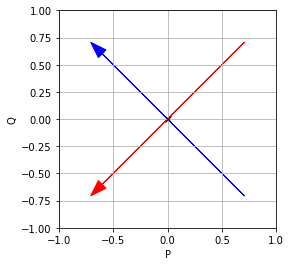

In [32]:
plot_rotation(t0)

The test coordinate was defined as zenith at `t0`. Evaluating the dipoles (in the PQR system) will rotate this point for one day.

In [19]:
from ipywidgets import interact, interactive, fixed, interact_manual

In [20]:
def plot_wrap(t: float):
    return plot_rotation(t0 + t * u.day)

In [21]:
interactive_plot = interactive(plot_wrap, t=(0., 1., 0.05))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.05), Output(layout=Layout(height…